# MacArthur Consumer Resource Model

In [6]:
import time
start = time.time()
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
#from scipy.linalg import norm
from numpy.linalg import norm
from functools import partial
plt.style.use("./styles/mystyle.mplstyle")
np.set_printoptions(suppress=True)
%matplotlib inline  

def create_parameter (number_species, number_resources):
    
    """ Funktion soll am Ende ein Dictionary bekommen, welches zufällige Werte beinhaltet, die zu den jeweiligen Parametern zugeordnet sind. 
    Die Anzahl der Werte der jeweiligen Parametern wird durch die Eingabe 'number_resources' und 'number_species' bestimmt. Im Gegensatz zu der Funktion
    'get_parameters' beinhaltet diese Funktion auch die Matrix a, die mit Zufallswerte gefüllt ist."""
    
    parameter_dict={}
    liste_parameter = []
    for i in ["w","r","K"]:
        parameter_dict[i] = np.repeat(1,number_resources)
            
    parameter_dict["T"] = np.repeat(0.2,number_species)
    parameter_dict["c"] = np.repeat(1,number_species)
    
    parameter_dict["number_species"] = len(parameter_dict["c"])
    parameter_dict["number_resources"] = len(parameter_dict["w"])
    
    a = np.random.rand(number_species,number_resources)
    a = a/a.sum(axis=1,keepdims=1)
    
    parameter_dict["a"] = a   
    
    return parameter_dict


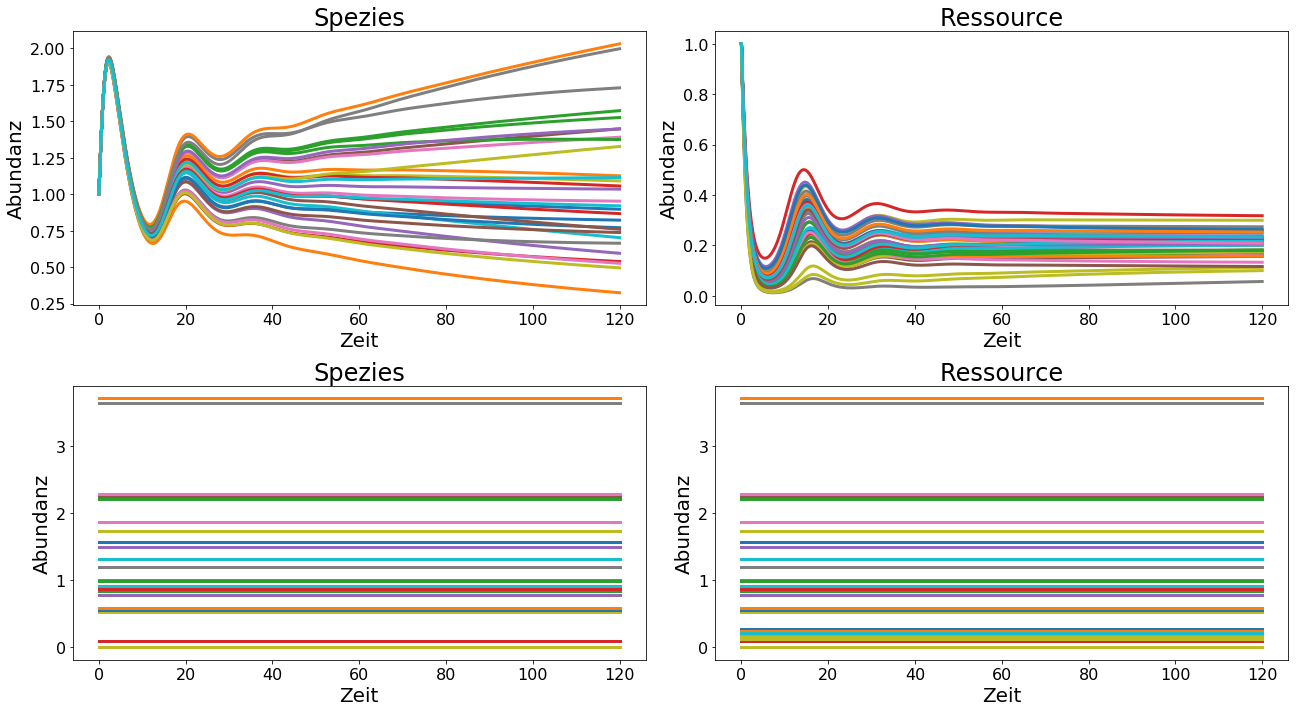

In [45]:
 

    
class MacArther_C_R_2():    # zum Testen für steady-state -> timecourse fehlt
   


    def __init__(self, dict_parameter): #when using the function the first time it asks for parameters
        self.dict_parameter = dict_parameter
        self.p = self.dict_parameter.copy()
        self.number_species = dict_parameter["number_species"]
        self.number_resources = dict_parameter["number_resources"]
        self.T = dict_parameter["T"]
        self.c = dict_parameter["c"]
        self.w = dict_parameter["w"]
        self.r = dict_parameter["r"]
        self.K = dict_parameter["K"]
        self.a = dict_parameter["a"]
        

    #h function
    def h(self, R):
        h = self.r * R / self.K * (self.K - R)
        return h

    #model
    def mcr(self, t,y):        
        X = y[:self.number_species]                            
        R = y[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)
        dRdt = self.h(R) - (self.a*R).T.dot(X)
        output = np.concatenate((dXdt,dRdt),axis=None)
        return output
    
    
    def timecourse(self, y, t):
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)            
        cnt = 1
        sol = [y]
        while cnt < len(t):
            sol.append(integ.integrate(t[cnt]))
            cnt += 1
        return np.array(sol)
    
    
    def steadystate(self,y, tmax = 10000000000, threshold=1e-9):                 
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)    
        ss = y
        t = range(tmax)
        cnt = 1
        while cnt < len(t):
            #print(cnt)
            ss_new = integ.integrate(t[cnt])
            if norm(ss-ss_new) < threshold:
                return ss_new
            else:
                ss = ss_new
                cnt += 1
                
    def R_steadystate(self):    # für 1-dimensionalen Fall
        R = self.T / (self.w * self.a)
        return R

    def X_steadystate(self):                 # für 1-dimensionalen Fall
        X = (self.r/self.a) * (1 - self.T / (self.w * self.a * self.K))
        return X

    
    
class Mit_Invader():
    
    def __init__ (self, MacArthur, y0, anfangswert = 1, anzahl = 1):
        self.dict_parameter = MacArthur
        self.number_species = MacArthur.number_species 
        self.number_resources = MacArthur.number_resources
        self.T = MacArthur.T
        self.c = MacArthur.c
        self.w = MacArthur.w
        self.r = MacArthur.r
        self.K = MacArthur.K
        self.a = MacArthur.a
        self.y0 = y0
        
        def expand_system (self, anzahl, anfangswert):
            X0 = self.y0[:self.number_species]
            R0 = self.y0[self.number_species:]

            for i in (range(anzahl)):

                self.T = np.append(self.T,0.2)
                self.c = np.append(self.c,1)
                g = np.random.rand( 1 , self.number_resources)
                g = g/g.sum(axis=1,keepdims=1)
                self.a = np.append(self.a,g,0)
                X0 = np.append(X0,anfangswert)
                self.number_species += 1
             
            self.y0 = np.concatenate((X0,R0),axis=None)

            return self.y0
            
        expand_system(self, anzahl, anfangswert)
 
    #h function
    def h(self, R):
        h = self.r * R / self.K * (self.K - R)
        return h

    #model
    def mcr(self, t, y):        
        X = y[:self.number_species]
        R = y[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)
        dRdt = self.h(R) - (self.a*R).T.dot(X)
        output = np.concatenate((dXdt,dRdt),axis=None)
        return output
    
    
    def timecourse(self, y, t):
        integ = ode(self.mcr).set_integrator('lsoda').set_initial_value(y,0)            
        cnt = 1
        sol = [y]
        while cnt < len(t):
            sol.append(integ.integrate(t[cnt]))
            cnt += 1
        return np.array(sol)
    
    def steadystate(self,x0,toleranz=1e-9):
        results0 = [x0]
        time=range(1000000000)
        error = np.linalg.norm(results0[0],ord=2)
        integrator = ode(self.mcr).set_integrator('lsoda').set_initial_value(x0,0)
        cnt=1
        while cnt < len(time) and error > toleranz and integrator.successful:
            zahl = integrator.integrate(time[cnt])
            error=np.linalg.norm(zahl-results0[-1],ord=2)
            results0.append(zahl) 
            cnt += 1
        return np.round(results0[-1],decimals=5)
    
    
    def fitness (self):
        X = self.y0[:self.number_species]
        R = self.y0[self.number_species:]
        dXdt = self.c*X*(np.sum(self.w*self.a*R,axis=1) - self.T)

        return dXdt
    

